# Players Similirity Analysis

In [3]:
## Importing Packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [148]:
players_data = pd.read_csv('../../data/understat_players_df.csv')

#### Coloring Configs

In [149]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set(style="darkgrid")

## Data Pre Processing

In [150]:
## Getting full season data
max_per_season_and_league = players_data.groupby(["League", "Season"]).agg({"aggregated_to_match":"max"}).reset_index()
players_df = pd.merge(players_data, max_per_season_and_league, on=["League", "Season", "aggregated_to_match"], how="inner")

players_df.head()


,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,...,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,League,Season,aggregated_to_match
0,2371,Cristiano Ronaldo,35,3103,48,39.308761,16,13.600642,225,76,...,1,F M,Real Madrid,38,30.389686,43.608020,7.520237,La_liga,2014,38
1,2097,Lionel Messi,38,3374,43,35.891764,18,17.611956,187,95,...,0,F S,Barcelona,38,31.432098,54.753610,19.756724,La_liga,2014,38
2,2099,Neymar,33,2573,22,22.721618,7,8.261543,95,52,...,0,F S,Barcelona,21,21.978340,36.888220,11.678407,La_liga,2014,38
3,2270,Antoine Griezmann,37,2490,22,14.709662,1,2.607721,78,23,...,0,F M S,Atletico Madrid,22,14.709662,18.479452,4.551564,La_liga,2014,38
4,1125,Carlos Bacca,36,2491,20,19.222722,6,4.423763,68,29,...,0,F S,Sevilla,14,13.277143,15.749522,2.668241,La_liga,2014,38


### Filtering 

In [151]:
## Filtering players that didn't play at all.
time_threshold = 20 * 90
players_df = players_df[players_df["time"] > time_threshold]

## Removing Goals Keeprs 
players_df = players_df[~players_df["position"].str.contains("GK")]

## Getting specifc season



In [152]:
players_df.head().T

,0,1,2,3,4
id,2371,2097,2099,2270,1125
player_name,Cristiano Ronaldo,Lionel Messi,Neymar,Antoine Griezmann,Carlos Bacca
games,35,38,33,37,36
time,3103,3374,2573,2490,2491
goals,48,43,22,22,20
xG,39.308761,35.891764,22.721618,14.709662,19.222722
assists,16,18,7,1,6
xA,13.600642,17.611956,8.261543,2.607721,4.423763
shots,225,187,95,78,68
key_passes,76,95,52,23,29


### Extracting features

In [153]:
players_df["time_played_ratio"] = players_df["time"]/(players_df["aggregated_to_match"] * 90)
players_df["npxG_to_npg_diff"] = players_df["npg"] - players_df["npxG"]
players_df["xA_to_assits_diff"] = players_df["xA"] - players_df["assists"]
players_df["shots_success_rate"] = players_df["goals"] / players_df["shots"]

### Normalizing Data per game

In [154]:
cols_to_normalize = [
    "npg",
    "npxG",
    "assists",
    "xA",
    "shots",
    "key_passes",
    "xGChain",
    "xGBuildup",
    "npxG_to_npg_diff",
    "xA_to_assits_diff"
]

for col in cols_to_normalize:
    players_df[f"{col}_pg"] = players_df[col] / (players_df["time"] / 90)

### Visualizing features distribution

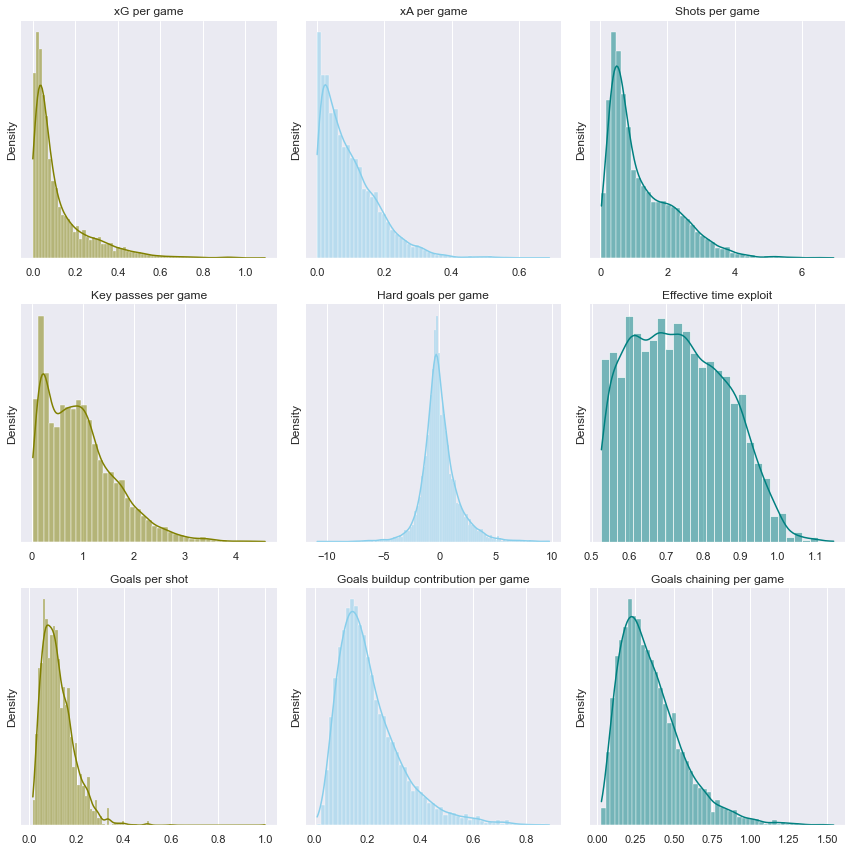

In [155]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))

features_to_plot = [("npxG_pg", "xG per game", "olive"), 
                    ("xA_pg", "xA per game", "skyblue"), 
                    ("shots_pg", "Shots per game", "teal"), 
                    ('key_passes_pg', 'Key passes per game', "olive"),
                    ('npxG_to_npg_diff', "Hard goals per game", "skyblue"), 
                    ('time_played_ratio', "Effective time exploit", "teal"),
                    ('shots_success_rate', "Goals per shot", "olive"),
                    ('xGBuildup_pg', "Goals buildup contribution per game", "skyblue"),
                    ('xGChain_pg', "Goals chaining per game", "teal")]

for idx,ax in enumerate(np.ravel(axs)):
    col, title, color = features_to_plot[idx]
    non_zero_subset = players_df[players_df[col] > 0] if col != "npxG_to_npg_diff" else players_df
    ax = sns.histplot(data=non_zero_subset, x=f"{col}", kde=True, color=f"{color}",stat="density", ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_yticks([])
    ax.set_xlabel("")
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)
fig.tight_layout()


### Ronaldo and Messi xG

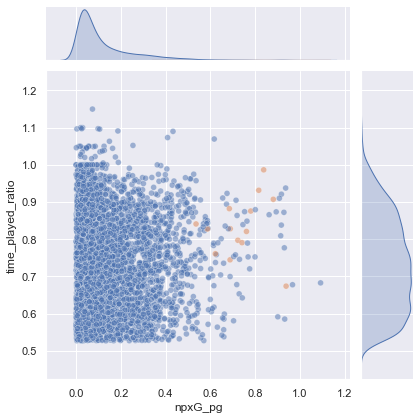

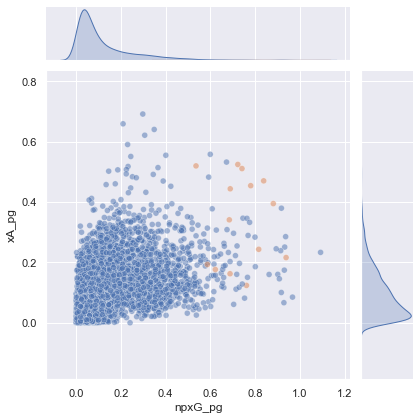

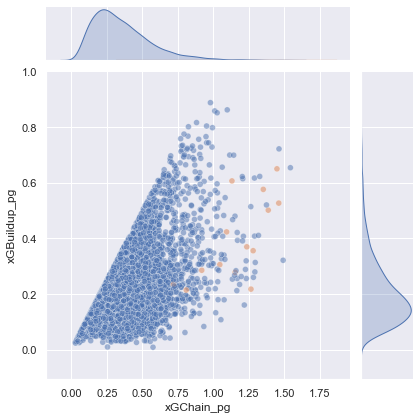

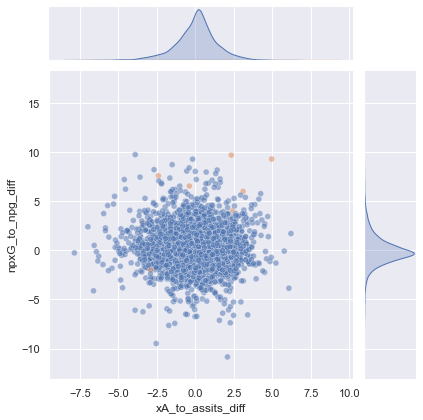

In [156]:
elite = players_df["id"].apply(lambda _id: _id in [2371, 2097])

pairs = [("npxG_pg", "time_played_ratio"),
         ("npxG_pg", "xA_pg"),
         ("xGChain_pg", "xGBuildup_pg"),
         ("xA_to_assits_diff", "npxG_to_npg_diff")
        ]

for pair in pairs:
    col1, col2 = pair
    g = sns.jointplot(data=players_df, x=col1,y=col2, hue=elite,alpha=0.5, 
                      kind="scatter", ax=ax, legend=False)


plt.show()

### Additional data wrangling

In [157]:
players_df["player_name_season"] = players_df["player_name"] + "_" + players_df["Season"].astype('str')

# Similiraity analysis

### Quantile Representations

Transforming Per game stats to quantiles representation

In [158]:
players_df.head().T

,0,1,2,3,4
id,2371,2097,2099,2270,1125
player_name,Cristiano Ronaldo,Lionel Messi,Neymar,Antoine Griezmann,Carlos Bacca
games,35,38,33,37,36
time,3103,3374,2573,2490,2491
goals,48,43,22,22,20
xG,39.308761,35.891764,22.721618,14.709662,19.222722
assists,16,18,7,1,6
xA,13.600642,17.611956,8.261543,2.607721,4.423763
shots,225,187,95,78,68
key_passes,76,95,52,23,29


In [159]:
from sklearn.metrics.pairwise import cosine_similarity
analysis_df = players_df[["player_name_season", "League", "npxG_pg", 
                          "xA_pg", "shots_pg", "key_passes_pg", "xGChain_pg",
                          "xGBuildup_pg", "npxG_to_npg_diff_pg", "xA_to_assits_diff_pg"]]




In [160]:
dist = 1 - cosine_similarity(analysis_df.iloc[:, 2:].to_numpy())


In [162]:
dist.shape

(5838, 5838)

In [187]:
import numpy as np 
from sklearn.cluster import AgglomerativeClustering


#cluster = AgglomerativeClustering(affinity='precomputed', linkage='complete') 
#cluster = AgglomerativeClustering(affinity='precomputed', linkage='average')
cluster = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=20)
cluster.fit(dist)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=20)

In [192]:
unique, counts = np.unique(cluster.labels_, return_counts=True)

In [193]:
cluster.labels_

array([10, 10, 10, ...,  1, 10, 13])

In [194]:
counts

array([1066,  108,  100,  432,  218,   51,  596,  116,   30,  556, 1282,
         45,   52,  550,    4,   13,  175,   16,  143,  285])

In [145]:
np.where(cluster.labels_ == 47)[0]

(array([    0,     4,     6, ..., 14246, 14263, 14274]),)

In [199]:
analysis_df.iloc[np.where(cluster.labels_ == 10)[0]].sort_values('shots_pg', ascending=False)

,player_name_season,League,npxG_pg,xA_pg,shots_pg,key_passes_pg,xGChain_pg,xGBuildup_pg,npxG_to_npg_diff_pg,xA_to_assits_diff_pg
0,Cristiano Ronaldo_2014,La_liga,0.881428,0.394476,6.525943,2.204318,1.264815,0.218118,0.220731,-0.069591
1599,Lionel Messi_2017,La_liga,0.780496,0.453768,5.889816,2.614357,1.447832,0.650116,0.181107,0.093167
3240,Lionel Messi_2020,La_liga,0.684932,0.340754,5.817037,2.296984,1.130798,0.606683,0.120503,0.072276
1058,Lionel Messi_2016,La_liga,0.689054,0.443489,5.688559,2.510593,1.351432,0.576277,0.296116,0.157472
2154,Lionel Messi_2018,La_liga,0.741598,0.510416,5.658284,3.095414,1.280099,0.356099,0.323490,0.077724
...,...,...,...,...,...,...,...,...,...,...
18711,Koffi Djidji_2017,Ligue_1,0.012262,0.009864,0.334988,0.186104,0.072621,0.059663,-0.012262,0.009864
3066,Ximo Navarro_2019,La_liga,0.011349,0.007086,0.328638,0.140845,0.058865,0.048928,-0.011349,0.007086
273,Jean-Sylvain Babin_2014,La_liga,0.031096,0.008514,0.306018,0.183611,0.064649,0.059916,-0.031096,0.008514
381,Ángel Trujillo_2014,La_liga,0.011540,0.024098,0.288369,0.144185,0.039924,0.034730,-0.011540,-0.004739
